# Capstone Project
## Image Classification of Dog Breeds

#### Problem Statement: 
Using images of Boston Bulls, Beagles, and Boxers from ImageNet, predict Boomer's mix of breeds.

*Import Necessary Libraries*

In [1]:
import warnings
warnings.filterwarnings('ignore')

%reload_ext autotime

In [2]:
from os import listdir
from keras.utils import np_utils
from imutils import paths

import keras as ks
from keras import backend as K
import cv2
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import restoration


Using TensorFlow backend.


time: 2.44 s


## Part 1: Get Images from ImageNet

I found an amazing [repo](https://github.com/tzutalin/ImageNet_Utils) with CLI commands to download images and crop using the provided bounding boxes from ImageNet.

In [ ]:
%%bash
git clone --recursive https://github.com/tzutalin/ImageNet_Utils.git
cd ImageNet_Utils

# Download images of the three breeds using their synset ID
# Boston: n02096585
# Beagle: n02088364
# Boxer:  n02108089

./downloadutils.py --downloadOriginalImages --wnid n02096585
./downloadutils.py --downloadOriginalImages --wnid n02088364
./downloadutils.py --downloadOriginalImages --wnid n02108089


# Download Bounding Boxes

./downloadutils.py --downloadBoundingBox --wnid n02096585
./downloadutils.py --downloadBoundingBox --wnid n02088364
./downloadutils.py --downloadBoundingBox --wnid n02108089


# Crop Images by Bounding Box XML

./bbox_helper.py --save_boundingbox --bxmldir n02096585/
./bbox_helper.py --save_boundingbox --bxmldir n02088364/
./bbox_helper.py --save_boundingbox --bxmldir n02108089/


# Create Train, Test subfolders for each breed

mkdir data/{train/{n02096585,n02088364,n02108089},test/{n02096585,n02088364,n02108089}}

In [2]:
# Determine the number of images to create a test set 
# consisting of 30% of each breed

test_n02096585 = len(listdir('data/n02096585'))*.3
test_n02088364 = len(listdir('data/n02088364'))*.3
test_n02108089 = len(listdir('data/n02108089'))*.3

#310, 393, 953 for train
print(test_n02096585,test_n02088364,test_n02108089)
#93, 118, 286 for test

496.2 567.6 599.4


In [ ]:
%%bash

# Randomly select 30% of each breed's images and move to test folder

shuf -zen93 data/n02088364/*  | xargs -0 mv -t data/test/n02088364
shuf -zen118 data/n02096585/*  | xargs -0 mv -t data/test/n02096585
shuf -zen286 data/n02108089/*  | xargs -0 mv -t data/test/n02108089


# Use remaining 70% as train folder

mv data/n02088364 data/train
mv data/n02096585 data/train
mv data/n02108089 data/train

## Part 2: Image Augmentation

Import images

*adapted from [source](http://machinelearningmastery.com/image-augmentation-deep-learning-keras/)*

In [112]:
# grab the list of images that we'll be describing
print("[INFO] describing images...")

## train ##
imagePaths = list(paths.list_images("data/train"))

# initialize the data matrix and labels list
trainData = []
trainLabels = []

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]

    # construct a feature vector raw pixel intensities, then update
    # the data matrix and labels list
    image = cv2.resize(image, (28,28))
    trainData.append(image)
    trainLabels.append(label)

    # show an update every 200 images
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")


## test ##
imagePaths = list(paths.list_images("data/test"))

# initialize the data matrix and labels list
testData = []
testLabels = []

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]

    # construct a feature vector raw pixel intensities, then update
    # the data matrix and labels list
    image = cv2.resize(image, (28,28))
    testData.append(image)
    testLabels.append(label)

    # show an update every 200 images
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")

[INFO] describing images...
[INFO] processed 200/3882
[INFO] processed 400/3882
[INFO] processed 600/3882
[INFO] processed 800/3882
[INFO] processed 1000/3882
[INFO] processed 1200/3882
[INFO] processed 1400/3882
[INFO] processed 1600/3882
[INFO] processed 1800/3882
[INFO] processed 2000/3882
[INFO] processed 2200/3882
[INFO] processed 2400/3882
[INFO] processed 2600/3882
[INFO] processed 2800/3882
[INFO] processed 3000/3882
[INFO] processed 3200/3882
[INFO] processed 3400/3882
[INFO] processed 3600/3882
[INFO] processed 3800/3882
[INFO] image processing complete
[INFO] processed 200/1662
[INFO] processed 400/1662
[INFO] processed 600/1662
[INFO] processed 800/1662
[INFO] processed 1000/1662
[INFO] processed 1200/1662
[INFO] processed 1400/1662
[INFO] processed 1600/1662
[INFO] image processing complete


In [113]:
#take out unique file identifers so that theyre all set to synset id
trainLabels = [i[0:9] for i in trainLabels]
testLabels = [i[0:9] for i in testLabels]

# encode the labels, converting them from strings to integers
le = LabelEncoder()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.fit_transform(testLabels)

# scale the input image pixels to the range [0, 1], then transform
# the labels into vectors in the range [0, 3] 
trainData = np.array(trainData) / 255.0
trainLabels = np_utils.to_categorical(trainLabels, 3)

testData = np.array(testData) / 255.0
testLabels = np_utils.to_categorical(testLabels, 3)

Perform Image Augmentation & Save Images

*adapted from [[source]](http://machinelearningmastery.com/image-augmentation-deep-learning-keras/)*

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import os
from os import listdir
from keras import backend as K
K.set_image_dim_ordering('tf')

time: 126 ms


In [115]:
# Save augmented images to file

# define data preparation
batch_size = 16


def image_augmentation(method,prefix,msg):

    # perform the specified augmentation
    datagen = method
    datagen.fit(trainData)
    i = 0

    generator = datagen.flow_from_directory('data/train/', target_size=(100,100),
        shuffle=False, batch_size=batch_size,
        save_to_dir='data/train',save_prefix=prefix)
   
    for batch in generator:
        i += 1
        if i > 20: # save 20 images
            break  # otherwise the generator would loop indefinitely
    
    images = generator.filenames
    classes = generator.classes
    print("Class Indices:",generator.class_indices)
    print(msg)
    print(len(listdir('data/train/'))-3," total augmented images")
    
    return images,classes

The following was actually run individually for each class due to issues in where images were saved and in how they were not named according to class.

In [118]:
# Flip Images
flip_imgs, flip_classes = image_augmentation(ImageDataGenerator(horizontal_flip=True, vertical_flip=True),'flip',"Saved flipped images")
# Shift Images
shift_imgs, shift_classes =image_augmentation(ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2),'shift',"Saved shifted images")
# Rotate Images
rotated_imgs, rotated_classes = image_augmentation(ImageDataGenerator(rotation_range=90),'rotate',"Saved rotated images")
# Center, Normalize Images
norm_imgs, norm_classes = image_augmentation(ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True),'norm',"Saved normalized images")

Found 1399 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved flipped images
334  total augmented images
Found 1399 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved shifted images
670  total augmented images
Found 1399 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved rotated images
1006  total augmented images
Found 1399 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved normalized images
1342  total augmented images


### Re-import all images, along with augmented ones

In [4]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

time: 1.42 ms


In [5]:
print("[INFO] describing images...")
## train ##
imagePaths = list(paths.list_images("data/train"))
# initialize the data matrix and labels list
trainData = []
trainLabels = []
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    
    image = cv2.resize(image, (32,32))
    trainData.append(image)
    
    trainLabels.append(label)
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")


## test ##
imagePaths = list(paths.list_images("data/test"))
testData = []
testLabels = []
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]

    image = cv2.resize(image, (32,32))
    testData.append(image)
    
    testLabels.append(label)
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")

[INFO] describing images...
[INFO] processed 200/7914
[INFO] processed 400/7914
[INFO] processed 600/7914
[INFO] processed 800/7914
[INFO] processed 1000/7914
[INFO] processed 1200/7914
[INFO] processed 1400/7914
[INFO] processed 1600/7914
[INFO] processed 1800/7914
[INFO] processed 2000/7914
[INFO] processed 2200/7914
[INFO] processed 2400/7914
[INFO] processed 2600/7914
[INFO] processed 2800/7914
[INFO] processed 3000/7914
[INFO] processed 3200/7914
[INFO] processed 3400/7914
[INFO] processed 3600/7914
[INFO] processed 3800/7914
[INFO] processed 4000/7914
[INFO] processed 4200/7914
[INFO] processed 4400/7914
[INFO] processed 4600/7914
[INFO] processed 4800/7914
[INFO] processed 5000/7914
[INFO] processed 5200/7914
[INFO] processed 5400/7914
[INFO] processed 5600/7914
[INFO] processed 5800/7914
[INFO] processed 6000/7914
[INFO] processed 6200/7914
[INFO] processed 6400/7914
[INFO] processed 6600/7914
[INFO] processed 6800/7914
[INFO] processed 7000/7914
[INFO] processed 7200/7914
[INF

In [6]:
#take out unique file identifers so that theyre all set to synset id
trainLabels = [i[0:9] for i in trainLabels]
testFiles = testLabels
testLabels = [i[0:9] for i in testLabels]
testFolders = testLabels

# encode the labels, converting them from strings to integers
le = LabelEncoder()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.fit_transform(testLabels)

# scale the input image pixels to the range [0, 1], then transform
# the labels into vectors in the range [0, 3]
trainData = np.array(trainData) / 255.0
trainLabels = np_utils.to_categorical(trainLabels, 3)

testData = np.array(testData) / 255.0
testLabels = np_utils.to_categorical(testLabels, 3)

print("[INFO] Cell Finished.")

[INFO] Cell Finished.
time: 168 ms


## Part 3: Modeling

In [7]:
from keras.models import Sequential
from keras.layers.core import Flatten
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import SGD

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

time: 2.84 ms


Create Convolutional Neural Network

*pretty sure adapted from this [source](http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/*)

In [9]:
depth = 3
height = 32
width = 32
classes = 3

time: 1.3 ms


In [10]:
model = Sequential()

pool_size = (3,3)
strides = (3,3)

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same', input_shape=(height, width, depth) ,data_format="channels_last"))
model.add(Dropout(0.5))

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=strides))

model.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=strides))

model.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=strides))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

time: 217 ms


In [11]:
# train, fit the model
K.set_image_dim_ordering('tf')
print("[INFO] compiling model...")

adam = ks.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss="categorical_crossentropy", optimizer=adam,
    metrics=["accuracy"])

model.fit(trainData, trainLabels, epochs=500, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/500
7914/7914 [==============================] - 3s - loss: 1.1007 - acc: 0.3351      

time: 19min 47s


In [12]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(testData, testLabels,
    batch_size=64, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,
    accuracy * 100))

[INFO] evaluating on testing set...
1600/1662 [===========================>..] - ETA: 0s[INFO] loss=0.5387, accuracy: 81.5283%
time: 307 ms


# Results

In [10]:
from matplotlib import pyplot as plt
from PIL import Image
import skimage.io as io

time: 1.07 s


In [11]:
# get predictions for each test image

imagePaths = list(paths.list_images("data/test"))
test_preds = []

for i in range(0, len(imagePaths)):
    
    # classify the digit
    probs = model.predict(testData[np.newaxis, i])
    preds = [round(i*100,5) for i in probs[0]]
    # record actual breed
    if testLabels[i][0]==1.0:
        actual='Beagle'
    elif testLabels[i][1]==1.0:
        actual='Boston'
    else:
        actual='Boxer'
    test_preds.append([imagePaths[i],preds[0],preds[1],preds[2],actual])
    
# Boston: n02096585 = 1
# Beagle: n02088364 = 0
# Boxer:  n02108089 = 2

time: 5.12 s


In [12]:
import pandas as pd

test_preds = pd.DataFrame(test_preds,columns=['Img','Beagle','Boston','Boxer','Actual'])

# determine breed with highest probability
test_preds['max']=''

for i in range(0,len(test_preds)):
    a,b,c = test_preds[['Beagle','Boston','Boxer']].ix[i]
    if (a>b) & (a>c):
        test_preds['max'].ix[i]='Beagle'
    elif b>c:
        test_preds['max'].ix[i]='Boston'
    else:
        test_preds['max'].ix[i]='Boxer'


time: 1min 58s


In [13]:
# count true and false positives

TP_Boxer = 0
TP_Beagle = 0
TP_Boston = 0

FP_Boxer = 0
FP_Beagle = 0
FP_Boston = 0

for i in range(0,len(test_preds)):
    if (test_preds['max'].ix[i]=='Boxer'):
        if (test_preds.Actual.ix[i]=='Boxer'):
            TP_Boxer+=1
        else:
            FP_Boxer+=1
    if (test_preds['max'].ix[i]=='Beagle'):
        if (test_preds.Actual.ix[i]=='Beagle'):
            TP_Beagle+=1
        else:
            FP_Beagle+=1
    if (test_preds['max'].ix[i]=='Boston'):
        if (test_preds.Actual.ix[i]=='Boston'):
            TP_Boston+=1
        else:
            FP_Boston+=1

time: 257 ms


In [14]:
print('True, False Positives by Breed:')
print('Boxer', (TP_Boxer, FP_Boxer))
print('Beagle', (TP_Beagle, FP_Beagle))
print('Boston', (TP_Boston, FP_Boston))

True, False Positives by Breed:
Boxer (463, 108)
Beagle (436, 63)
Boston (456, 136)
time: 2.89 ms


In [15]:
total = len(testData)
from sklearn.metrics import confusion_matrix, classification_report

true_labels = le.fit_transform(testFolders)
predicted_labels = [0 if dog=='Beagle' else 1 if dog=='Boston' else 2 for dog in test_preds['max'].tolist()]

cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2])
cm = pd.DataFrame(cm,columns=['Beagle','Boston','Boxer'],index=['Predicted Beagle','Predicted Boston','Predicted Boxer'])


print("Classification Report")
print(classification_report(true_labels, predicted_labels))
print()
print("Confusion Matrix")
cm

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.77      0.82       567
          1       0.77      0.92      0.84       496
          2       0.81      0.77      0.79       599

avg / total       0.82      0.82      0.81      1662


Confusion Matrix


Beagle  Boston  Boxer
Predicted Beagle     436      51     80
Predicted Boston      12     456     28
Predicted Boxer       51      85    463

time: 23.9 ms


In [16]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

time: 7.29 ms


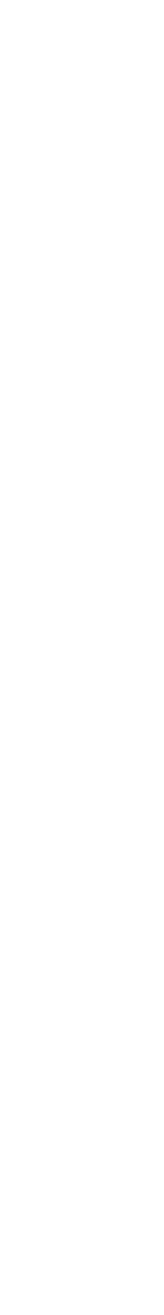

time: 5.47 s


In [48]:
%matplotlib inline
from keras.preprocessing import image


f = plt.figure(figsize=(30,90))
rows = 5


path = 'data/test/'


imgs= []
test_summary =[]
pics = np.random.choice(range(len(testData)),20)

for i,j in enumerate(pics):
    sp = f.add_subplot(rows, len(testData)//rows, i+1)
    sp.axis('Off')

    # classify the digit
    probs = model.predict(testData[np.newaxis, i])
    picJPEG = path+testFiles[j][0:9]+'/'+testFiles[j]+'.JPEG'
    picjpeg = path+testFiles[j][0:9]+'/'+testFiles[j]+'.jpeg'
    try:
        image = io.imread(picJPEG)
    except:
        image = io.imread(picjpeg)
    preds = [round(i*100,2) for i in probs[0]]
    test_summary.append([testFiles[j],preds[0],preds[1],preds[2]])

        f.tight_layout(pad=0.1)
    
    im = cv2.resize(image, (200,200))
    imgs.append(im)

test_summary = pd.DataFrame(test_summary,columns=['File','Beagle','Boston','Boxer'])

In [52]:
# determine breed with highest probability
test_summary['max']=''

for i in range(0,len(test_summary)):
    a,b,c = test_summary[['Beagle','Boston','Boxer']].ix[i]
    if (a>b) & (a>c):
        test_summary['max'].ix[i]='Beagle'
    elif b>c:
        test_summary['max'].ix[i]='Boston'
    else:
        test_summary['max'].ix[i]='Boxer'


time: 2.21 s


Look at the predicted breeds for some of the test images

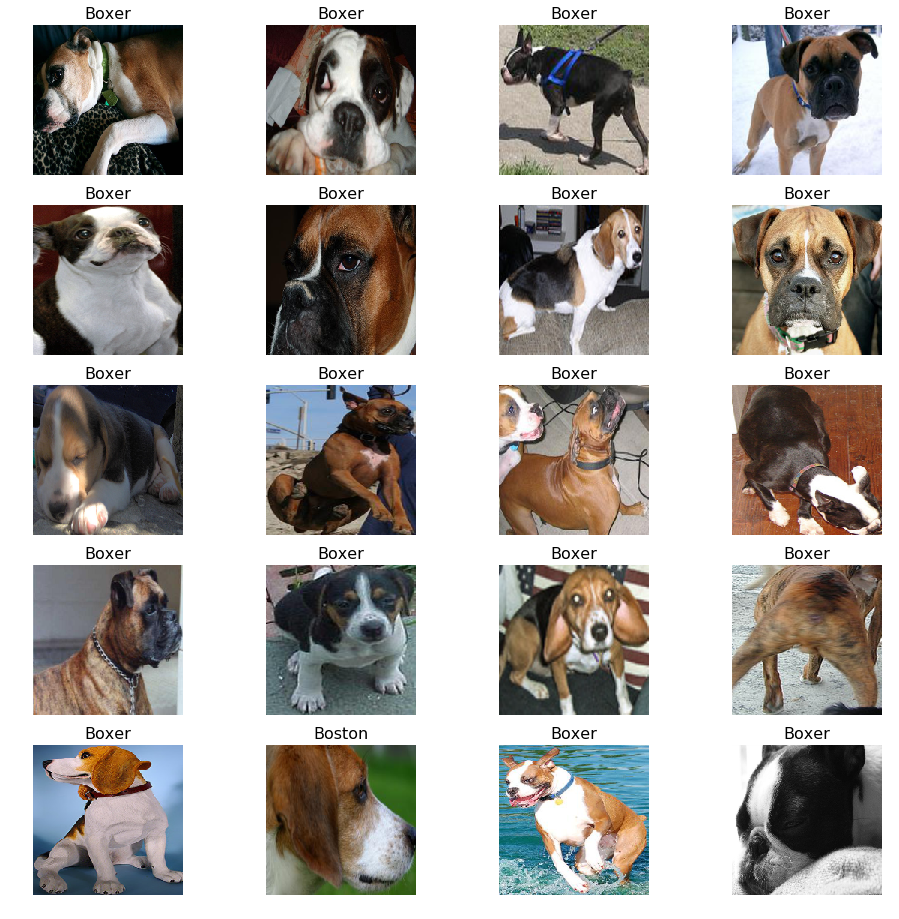

time: 2.45 s


In [53]:
plots(imgs,figsize=(16,16), titles=test_summary['max'], rows=5)

# Final Test: Boomer

In [39]:
## test ##
imagePaths = list(paths.list_images("Boomer"))
boomerData = []
boomerFiles = []
# testLabels = []
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (32,32))
    boomerData.append(image)
    boomerFiles.append(imagePath)
    if i > 0 and i % 10 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))

boomerData = np.array(boomerData) / 255.0
print("[INFO] image processing complete")


[INFO] processed 10/32
[INFO] processed 20/32
[INFO] processed 30/32
[INFO] image processing complete
time: 6.63 s


In [71]:
%matplotlib inline
boomer = []

i = 0
for boom in boomerData:
    # classify the digit
    probs = model.predict(boomerData[np.newaxis, i])    
    image = io.imread(boomerFiles[i])
    preds = [round(i*100,5) for i in probs[0]]
    boomer.append([boomerFiles[i],preds[0],preds[1],preds[2]])
    i+=1
rows = 8
boomer = pd.DataFrame(boomer,columns=['File','Beagle','Boston','Boxer'])

time: 8.13 s


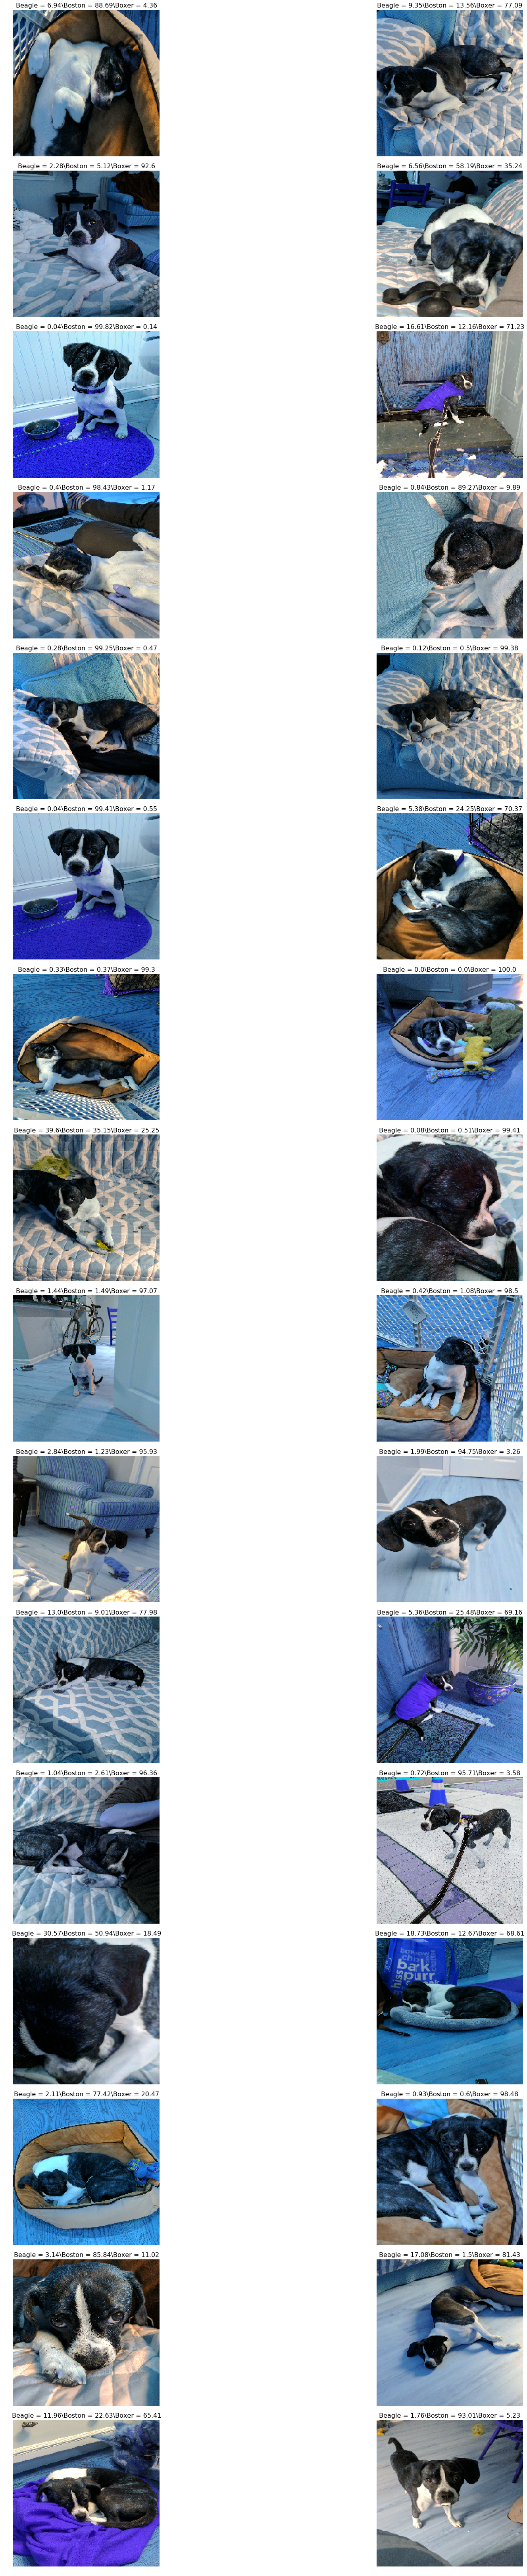

time: 19.3 s


In [105]:
f = plt.figure(figsize=(30,90))
rows = 16
for i in range(len(boomerData)):
        sp = f.add_subplot(rows, len(boomerData)//rows, i+1)
        sp.axis('Off')

        sp.set_title("Beagle = {}\\Boston = {}\\Boxer = {}".format(round(boomer.Beagle.ix[i],2), round(boomer.Boston.ix[i],2), round(boomer.Boxer.ix[i],2)), fontsize=16)
        f.tight_layout(pad=0.1)
#         plt.figure(figsize=(8,8))

        im = cv2.imread(boomerFiles[i])
        im = cv2.resize(im, (200,200))


        plt.imshow(im)
    
# Beagle: n02088364 = 0    
# Boston: n02096585 = 1
# Boxer:  n02108089 = 2


In [103]:
import pandas as pd

# determine the breed with the highest probability
boomer['max']=''

for i in range(0,len(boomer)):
    a,b,c = boomer[['Beagle','Boston','Boxer']].ix[i]
    if (a>b) & (a>c):
        boomer['max'].ix[i]='Beagle'
    elif b>c:
        boomer['max'].ix[i]='Boston'
    else:
        boomer['max'].ix[i]='Boxer'


time: 5.61 s


In [104]:
boomer['max'].groupby(boomer['max']).count()

max
Beagle     1
Boston    13
Boxer     18
Name: max, dtype: int64

time: 5.54 ms


# Evaluation:

I'm not very satisfied by my model, considering I have a biased opinion that Boomer is most definitely part Beagle. He has the same floppy ears and white tipped tail! I might have to do some thorough examination of the Beagle training photos to ensure that enough images show the ears and tail. 

Sorry Boomer; still don't know what breed your dad was.